## Cell 2: Import Required Libraries

Import thư viện cần thiết:
- **Data handling**: Pandas, NumPy
- **Clustering**: K-Means, StandardScaler
- **Metrics**: Silhouette, Davies-Bouldin, Calinski-Harabasz
- **Visualization**: Matplotlib, Seaborn, Plotly
- **Association Rules**: MLXtend
- **Config**: Pandas display options

In [1]:
# ============================================================================
# 1. IMPORT REQUIRED LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Visualization
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Tất cả thư viện đã import thành công")
print(f"  - Clustering: K-Means, StandardScaler")
print(f"  - Metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz")
print(f"  - Association Rules: MLXtend")
print(f"  - Visualization: Matplotlib, Seaborn, Plotly")

✓ Tất cả thư viện đã import thành công
  - Clustering: K-Means, StandardScaler
  - Metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz
  - Association Rules: MLXtend
  - Visualization: Matplotlib, Seaborn, Plotly


## Cell 3: Load and Prepare Data

Tải dữ liệu cho 3 góc nhìn phân cụm khác nhau:

### Data Sources:

**1. Transactions Data** (`cleaned_uk_data.csv`)

- Giao dịch đã làm sạch của UK customers

- Chứa: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, Price, CustomerID- Ready cho 3 clustering approaches

- Dùng để: Hiểu transaction patterns, validate results- Hiển thị thông tin chi tiết về kích thước, columns

- Cả 4 datasets được load thành công

**2. Basket Matrix** (`basket_bool.parquet`)### Expected Output:

- **Shape**: (n_transactions × n_products)

- **Format**: Boolean matrix (1 = mua, 0 = không mua)4. Validate dữ liệu (check nulls, types)

- **Purpose**: Basket Clustering - phân cụm giỏ hàng/transactions3. Hiển thị shape, columns, summary statistics

- **Interpretation**: Mỗi hàng là 1 transaction, mỗi cột là 1 sản phẩm2. Load 4 datasets

1. Set paths đến thư mục data (processed, features, clusters)

**3. Association Rules** (`rules_apriori_filtered.csv`)### Data Loading Process:

- Rules từ Apriori algorithm (filtered)

- **Columns**: antecedents, consequents, support, confidence, lift- **Purpose**: Reference cho Product Clustering (tạo co-purchase matrix)

- **Purpose**: Rule Clustering - phân cụm luật liên kết- **Features**: Product purchase frequencies, RFM metrics, transaction patterns

- **Metrics**: - **Shape**: (n_customers × 175 features)

  - Support: Tần suất xuất hiện của itemset**4. Customer Features** (`variant_a_weighted.csv`)

  - Confidence: Xác suất có điệu kiện P(B|A)
  - Lift: Mức độ liên kết giữa A và B

In [2]:
# ============================================================================
# 2. LOAD AND PREPARE DATA
# ============================================================================
print("\n" + "=" * 70)
print("LOAD AND PREPARE DATA")
print("=" * 70)

# Set paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
processed_dir = data_dir / 'processed'
features_dir = data_dir / 'features'
clusters_dir = data_dir / 'clusters'

# Load data
print("\n📂 Đang tải dữ liệu...")

# 1. Load cleaned transaction data
transactions_df = pd.read_csv(processed_dir / 'cleaned_uk_data.csv')
print(f"\n✓ Transactions: {transactions_df.shape[0]:,} rows, {transactions_df.shape[1]} columns")
print(f"  - Columns: {list(transactions_df.columns[:5])}...")

# 2. Load basket matrix (transaction × product)
basket_bool = pd.read_parquet(processed_dir / 'basket_bool.parquet')
print(f"\n✓ Basket Matrix: {basket_bool.shape[0]} transactions, {basket_bool.shape[1]} products")

# 3. Load association rules
rules_df = pd.read_csv(processed_dir / 'rules_apriori_filtered.csv')
print(f"\n✓ Association Rules: {rules_df.shape[0]} rules")
print(f"  - Columns: {list(rules_df.columns[:5])}...")

# 4. Load customer features
customer_features = pd.read_csv(features_dir / 'variant_a_weighted.csv', index_col=0)
print(f"\n✓ Customer Features: {customer_features.shape[0]} customers, {customer_features.shape[1]} features")

print(f"\n{'=' * 70}")
print("Dữ liệu sẵn sàng cho phân cụm từ 3 góc nhìn khác nhau")


LOAD AND PREPARE DATA

📂 Đang tải dữ liệu...

✓ Transactions: 485,123 rows, 11 columns
  - Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate']...

✓ Basket Matrix: 18021 transactions, 4007 products

✓ Association Rules: 175 rules
  - Columns: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support']...

✓ Customer Features: 3921 customers, 175 features

Dữ liệu sẵn sàng cho phân cụm từ 3 góc nhìn khác nhau


## Cell 4: Basket Clustering

Phân cụm giỏ hàng (Transaction-Level Clustering):

### Approach Overview:
- **Clustering Level**: Transaction level
- **Input**: Basket boolean matrix (n_transactions × n_products)
- **Goal**: Nhóm transactions có mô hình mua sắm tương tự



### Input Data Details:- **Personalization**: Target promotions theo transaction type

- **Matrix Shape**: (n_transactions, n_products)- **Logistics**: Tối ưu warehouse layout theo basket patterns

- **Values**: Binary (0/1) - sản phẩm có trong giỏ hàng hay không- **Bundling**: Tạo package deals cho mỗi cụm

- **Interpretation**: Mỗi transaction là 1 vector binary- **Cross-sell**: Recommend sản phẩm cho mỗi loại giỏ hàng

- **Example**: Transaction A = [1, 0, 1, 0, ...] có nghĩa mua sản phẩm 1 và 3### Marketing Applications:



### Clustering Process:- **Cụm 3**: "Bulk/Wholesale Orders" (>10 items)

- **Cụm 2**: "Large Diverse Baskets" (6-10 items)

**Bước 1: Standardization**- **Cụm 1**: "Medium Mixed Baskets" (3-5 items)

- Chuẩn hóa matrix bằng StandardScaler- **Cụm 0**: Ví dụ - "Small Simple Baskets" (1-2 items)

- Tạo features có mean=0, std=1### Business Interpretation:

- Cần thiết cho K-Means (distance-based)

- **Quality Metrics**: Silhouette, DBI, CH Index, Inertia

**Bước 2: K-Means Clustering**- **Cluster Distribution**: Số lượng và % transactions trong mỗi cụm

- Algorithm: K-Means- **Cluster Labels**: Mỗi transaction được gán vào 1 cụm (0-3)

- K = 4 cụm (từ phân tích trước)### Output Metrics:

- Parameters: n_init=20, random_state=42

- Inertia: Within-cluster sum of squares

**Bước 3: Evaluation**- Calinski-Harabasz: Variance ratio

- Silhouette Score: Separation quality- Davies-Bouldin: Compactness

In [3]:
# ============================================================================
# 3. BASKET CLUSTERING (Phân cụm Giỏ Hàng / Transactions)
# ============================================================================
print("\n" + "=" * 70)
print("BASKET CLUSTERING - PHÂN CỤM GIỎ HÀNG")
print("=" * 70)

# Sử dụng basket_bool matrix trực tiếp (transaction × product)
# Mỗi transaction là một hàng, mỗi sản phẩm là một cột
print(f"\n✓ Input: Basket Boolean Matrix")
print(f"  - Shape: {basket_bool.shape}")
print(f"  - Transactions: {basket_bool.shape[0]}")
print(f"  - Products: {basket_bool.shape[1]}")
print(f"  - Data type: {basket_bool.dtypes.unique()}")

# Standardize
scaler_basket = StandardScaler()
basket_scaled = scaler_basket.fit_transform(basket_bool)

# Apply K-Means (K=4 từ customer clustering)
k = 4
basket_kmeans = KMeans(n_clusters=k, n_init=20, random_state=42, verbose=0)
basket_labels = basket_kmeans.fit_predict(basket_scaled)

# Metrics
basket_silhouette = silhouette_score(basket_scaled, basket_labels)
basket_dbi = davies_bouldin_score(basket_scaled, basket_labels)
basket_ch = calinski_harabasz_score(basket_scaled, basket_labels)
basket_inertia = basket_kmeans.inertia_

print(f"\n✓ K-Means Clustering (K={k}):")
print(f"  - Inertia: {basket_inertia:.2f}")
print(f"  - Silhouette Score: {basket_silhouette:.4f}")
print(f"  - Davies-Bouldin Index: {basket_dbi:.4f}")
print(f"  - Calinski-Harabasz Index: {basket_ch:.2f}")

# Cluster distribution
basket_counts = pd.Series(basket_labels).value_counts().sort_index()
print(f"\n✓ Phân bố cụm:")
for cluster_id, count in basket_counts.items():
    pct = 100 * count / len(basket_labels)
    print(f"  - Cụm {cluster_id}: {count:,} transactions ({pct:.1f}%)")

# Lưu kết quả
basket_clustering_results = {
    'labels': basket_labels,
    'silhouette': basket_silhouette,
    'dbi': basket_dbi,
    'ch': basket_ch,
    'inertia': basket_inertia,
    'model': basket_kmeans
}


BASKET CLUSTERING - PHÂN CỤM GIỎ HÀNG

✓ Input: Basket Boolean Matrix
  - Shape: (18021, 4007)
  - Transactions: 18021
  - Products: 4007
  - Data type: [dtype('bool')]

✓ K-Means Clustering (K=4):
  - Inertia: 69804217.42
  - Silhouette Score: 0.4744
  - Davies-Bouldin Index: 3.9328
  - Calinski-Harabasz Index: 207.00

✓ Phân bố cụm:
  - Cụm 0: 2 transactions (0.0%)
  - Cụm 1: 97 transactions (0.5%)
  - Cụm 2: 17,601 transactions (97.7%)
  - Cụm 3: 321 transactions (1.8%)


## Cell 5: Product Clustering

Phân cụm sản phẩm (Product-Level Clustering):

### Approach Overview:
- **Clustering Level**: Product level
- **Input**: Co-purchase matrix (n_products × n_products)
- **Goal**: Nhóm sản phẩm thường được mua cùng nhau


### Co-Purchase Matrix Construction:

- Direct business impact - visual merchandising, layout

**Bước 1: Transpose Basket Matrix**- High actionability - triển khai ngay vào merchandising

- basket_bool: (n_transactions × n_products)- High interpretability - dễ giải thích cho team

- basket_T: (n_products × n_transactions)### Advantages:



**Bước 2: Matrix Multiplication**- **Category Management**: Tổ chức product categories

- co-purchase = basket_T @ basket_T.T- **Pricing**: Chính sách giá nhất quán cho cùng cụm

- Kết quả: (n_products × n_products) matrix- **Bundling**: Tạo combo từ products trong cùng cụm

- co-purchase[i, j] = số lần product i và j được mua cùng nhau- **Recommendations**: "Customers who bought X also bought Y"

- **Product Placement**: Xếp sản phẩm cùng cụm gần nhau trong store

**Bước 3: Normalization**### Marketing Applications:

- Chia cho diagonal (tần suất mua của từng product)

- Tạo similarity matrix [0, 1]- **Cụm 3**: "Personal Care & Beauty"

- Điều chỉnh bias từ popular products- **Cụm 2**: "Party & Celebration" goods

- **Cụm 1**: "Gift & Decoration" items

**Bước 4: Distance Matrix**- **Cụm 0**: "Kitchen & Home" products

- distance = 1 - similarity### Business Interpretation:

- Chuyển similarity thành distance metric

- Cao = ít co-purchase, Thấp = nhiều co-purchase- **Quality Metrics**: Đánh giá chất lượng cụm

- **Cluster Size**: Số lượng products trong mỗi cụm

### Clustering Process:- **Product Labels**: Mỗi product thuộc 1 cụm (0-3)

### Output Metrics:

**Standardization**: StandardScaler lên distance matrix

**K-Means**: K=4 cụm, n_init=20**Evaluation**: Silhouette, DBI, CH, Inertia

In [4]:
# ============================================================================
# 4. PRODUCT CLUSTERING (Phân cụm Sản Phẩm)
# ============================================================================
print("\n" + "=" * 70)
print("PRODUCT CLUSTERING - PHÂN CỤM SẢN PHẨM")
print("=" * 70)

# Tạo product co-purchase matrix
# Product × Product: tần suất co-purchase
print(f"\n✓ Tạo Co-Purchase Matrix (Product × Product)")

# Transpose để có product × transaction, sau đó tính co-purchase
basket_T = basket_bool.T  # (n_products, n_transactions)
copurchase_matrix = basket_T @ basket_T.T  # (n_products, n_products)

print(f"  - Co-Purchase Matrix shape: {copurchase_matrix.shape}")
print(f"  - Thể hiện tần suất 2 sản phẩm được mua cùng nhau")

# Normalize bằng cách chia cho diagonal
copurchase_normalized = copurchase_matrix.copy()
diag = np.diag(copurchase_matrix)
copurchase_normalized = copurchase_normalized / (diag[:, None] + 1e-10)  # Tránh division by zero

# Convert to similarity (0 to 1)
copurchase_normalized = np.clip(copurchase_normalized, 0, 1)

# Tạo distance matrix từ similarity
product_distance = 1 - copurchase_normalized

# Standardize distance matrix
scaler_product = StandardScaler()
product_distance_scaled = scaler_product.fit_transform(product_distance)

# Apply K-Means (K=4)
product_kmeans = KMeans(n_clusters=k, n_init=20, random_state=42, verbose=0)
product_labels = product_kmeans.fit_predict(product_distance_scaled)

# Metrics
product_silhouette = silhouette_score(product_distance_scaled, product_labels)
product_dbi = davies_bouldin_score(product_distance_scaled, product_labels)
product_ch = calinski_harabasz_score(product_distance_scaled, product_labels)
product_inertia = product_kmeans.inertia_

print(f"\n✓ K-Means Clustering (K={k}):")
print(f"  - Inertia: {product_inertia:.2f}")
print(f"  - Silhouette Score: {product_silhouette:.4f}")
print(f"  - Davies-Bouldin Index: {product_dbi:.4f}")
print(f"  - Calinski-Harabasz Index: {product_ch:.2f}")

# Cluster distribution
product_counts = pd.Series(product_labels).value_counts().sort_index()
print(f"\n✓ Phân bố cụm sản phẩm:")
for cluster_id, count in product_counts.items():
    pct = 100 * count / len(product_labels)
    print(f"  - Cụm {cluster_id}: {count} sản phẩm ({pct:.1f}%)")

# Lưu kết quả
product_clustering_results = {
    'labels': product_labels,
    'silhouette': product_silhouette,
    'dbi': product_dbi,
    'ch': product_ch,
    'inertia': product_inertia,
    'model': product_kmeans,
    'product_names': basket_bool.columns.tolist()
}


PRODUCT CLUSTERING - PHÂN CỤM SẢN PHẨM

✓ Tạo Co-Purchase Matrix (Product × Product)
  - Co-Purchase Matrix shape: (4007, 4007)
  - Thể hiện tần suất 2 sản phẩm được mua cùng nhau

✓ K-Means Clustering (K=4):
  - Inertia: 9929611.16
  - Silhouette Score: 0.1142
  - Davies-Bouldin Index: 2.8593
  - Calinski-Harabasz Index: 823.27

✓ Phân bố cụm sản phẩm:
  - Cụm 0: 1143 sản phẩm (28.5%)
  - Cụm 1: 827 sản phẩm (20.6%)
  - Cụm 2: 847 sản phẩm (21.1%)
  - Cụm 3: 1190 sản phẩm (29.7%)


## Cell 6: Rule Clustering

Phân cụm luật liên kết (Association Rules Clustering):

### Approach Overview:
- **Clustering Level**: Rule level (meta-level)
- **Input**: Rule characteristics (support, confidence, lift)
- **Goal**: Nhóm association rules có đặc điểm tương tự



### Association Rule Metrics:- Phụ thuộc vào chất lượng rules ban đầu

- Quá nhiều rules → khó quản lý

**1. Support**:- Khó interpret hơn Basket/Product clustering

- **Definition**: P(A ∪ B) - Tần suất xuất hiện của {A, B}### Challenges:

- **Range**: [0, 1]

- **Interpretation**: Cao = rule phổ biến, Thấp = rule hiếm- **Content Marketing**: Story-telling từ interesting rules

- **Hypothesis Testing**: Validate marketing assumptions

**2. Confidence**:- **Strategic Insights**: Hiểu mối quan hệ sản phẩm

- **Definition**: P(B|A) = P(A ∪ B) / P(A)- **Rule Prioritization**: Tập trung vào cụm "golden rules"

- **Range**: [0, 1]### Marketing Applications:

- **Interpretation**: Xác suất mua B khi đã mua A

  - "Golden rules" - Best for marketing

**3. Lift**:- **Cụm 3**: Moderate support, moderate confidence, very high lift

- **Definition**: P(B|A) / P(B)  

- **Range**: [0, ∞), baseline = 1  - "Common weak rules" - Obvious but not actionable

- **Interpretation**:- **Cụm 2**: High support, moderate confidence, low lift

  - Lift > 1: A và B xuất hiện cùng nhau nhiều hơn ngẫu nhiên  

  - Lift = 1: Độc lập  - "Niche strong rules" - Hidden gems

  - Lift < 1: Phủ định nhau- **Cụm 1**: Low support, high confidence, high lift

  

### Feature Engineering for Rules:  - "Popular reliable rules" - Mainstream patterns

- **Cụm 0**: High support, high confidence, moderate lift

**Input Features**:**Cluster Profiles** (ví dụ):

- support: Tần suất rule

- confidence: Độ tin cậy### Output Interpretation:

- lift: Mức độ liên kết

- Tính Silhouette, DBI, CH Index

**Optional Features** (nếu có):**Bước 4: Evaluation**

- leverage: Support(A∪B) - Support(A)×Support(B)

- conviction: (1-Support(B)) / (1-Confidence)- n_init=20, random_state=42

- K=4 cụm

### Clustering Process:**Bước 3: K-Means**



**Bước 1: Feature Selection**- Cần thiết vì support, confidence, lift có range khác nhau

- Kiểm tra columns available trong rules_df- StandardScaler để đưa về cùng scale

- Chọn tối thiểu 2 features (support, confidence, lift)**Bước 2: Standardization**


In [5]:
# ============================================================================
# 5. RULE CLUSTERING (Phân cụm Luật Liên Kết)
# ============================================================================
print("\n" + "=" * 70)
print("RULE CLUSTERING - PHÂN CỤM LUẬT LIÊN KẾT")
print("=" * 70)

print(f"\n✓ Input: Association Rules")
print(f"  - Number of rules: {rules_df.shape[0]}")
print(f"  - Columns: {list(rules_df.columns[:5])}")

# Chuẩn bị features cho rule clustering
# Sử dụng: support, confidence, lift, leverage, conviction
rule_features_cols = ['support', 'confidence', 'lift']
rule_features_available = [col for col in rule_features_cols if col in rules_df.columns]

print(f"\n✓ Rule Features sử dụng: {rule_features_available}")

if len(rule_features_available) >= 2:
    X_rules = rules_df[rule_features_available].values
    
    # Standardize
    scaler_rules = StandardScaler()
    X_rules_scaled = scaler_rules.fit_transform(X_rules)
    
    # Apply K-Means (K=4)
    rule_kmeans = KMeans(n_clusters=k, n_init=20, random_state=42, verbose=0)
    rule_labels = rule_kmeans.fit_predict(X_rules_scaled)
    
    # Metrics
    rule_silhouette = silhouette_score(X_rules_scaled, rule_labels)
    rule_dbi = davies_bouldin_score(X_rules_scaled, rule_labels)
    rule_ch = calinski_harabasz_score(X_rules_scaled, rule_labels)
    rule_inertia = rule_kmeans.inertia_
    
    print(f"\n✓ K-Means Clustering (K={k}):")
    print(f"  - Inertia: {rule_inertia:.2f}")
    print(f"  - Silhouette Score: {rule_silhouette:.4f}")
    print(f"  - Davies-Bouldin Index: {rule_dbi:.4f}")
    print(f"  - Calinski-Harabasz Index: {rule_ch:.2f}")
    
    # Cluster distribution
    rule_counts = pd.Series(rule_labels).value_counts().sort_index()
    print(f"\n✓ Phân bố cụm luật:")
    for cluster_id, count in rule_counts.items():
        pct = 100 * count / len(rule_labels)
        print(f"  - Cụm {cluster_id}: {count} luật ({pct:.1f}%)")
    
    # Lưu kết quả
    rule_clustering_results = {
        'labels': rule_labels,
        'silhouette': rule_silhouette,
        'dbi': rule_dbi,
        'ch': rule_ch,
        'inertia': rule_inertia,
        'model': rule_kmeans
    }
else:
    print("\n⚠️  Không đủ features để phân cụm luật")
    rule_clustering_results = None


RULE CLUSTERING - PHÂN CỤM LUẬT LIÊN KẾT

✓ Input: Association Rules
  - Number of rules: 175
  - Columns: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support']

✓ Rule Features sử dụng: ['support', 'confidence', 'lift']

✓ K-Means Clustering (K=4):
  - Inertia: 203.08
  - Silhouette Score: 0.3407
  - Davies-Bouldin Index: 1.0018
  - Calinski-Harabasz Index: 90.35

✓ Phân bố cụm luật:
  - Cụm 0: 45 luật (25.7%)
  - Cụm 1: 39 luật (22.3%)
  - Cụm 2: 18 luật (10.3%)
  - Cụm 3: 73 luật (41.7%)


## Cell 7: Metrics Comparison

So sánh chi tiết metrics của 3 góc nhìn clustering:

### Metrics Được Sử Dụng:

**1. Silhouette Score** (Higher is Better)
- **Range**: [-1, 1]

- **Ý Nghĩa**: Đo độ tách biệt giữa các cụm

- **Interpretation**:- Chọn approach tốt nhất cho business goals

  - > 0.7: Excellent separation- Kết hợp metrics với interpretability & actionability

  - 0.5-0.7: Good separation### Next Steps:

  - 0.25-0.5: Weak separation

  - < 0.25: Poor/no separation- Winner theo từng metric

- **Formula**: (b - a) / max(a, b)- Visual comparison (bar charts)

  - a = average distance đến các điểm trong cụm- 3 rankings (1 cho mỗi metric)

  - b = average distance đến các điểm cụm gần nhất- Bảng so sánh chi tiết

### Output:

**2. Davies-Bouldin Index** (Lower is Better)

- **Range**: [0, ∞)- Cần cân nhắc giữa metrics và business value

- **Ý Nghĩa**: Ratio của within-cluster và between-cluster distances- Không có approach nào win tất cả metrics

- **Interpretation**:**Trade-offs**:

  - < 1.0: Excellent

  - 1.0-1.5: Good- **Rule Clustering**: CH Index cao (high variance ratio)

  - 1.5-2.0: Fair- **Basket Clustering**: DBI thấp (compact transactions)

  - > 2.0: Poor- **Product Clustering**: Thường có Silhouette cao nhất (clear product groups)

- **Formula**: Average maximum ratio giữa clusters**Typical Results**:



**3. Calinski-Harabasz Index** (Higher is Better)### Expected Insights:

- **Range**: [0, ∞)

- **Ý Nghĩa**: Ratio giữa between-cluster và within-cluster variance- Rank theo Calinski-Harabasz (cao → thấp)

- **Interpretation**:- Rank theo Davies-Bouldin (thấp → cao)

  - > 1000: Excellent- Rank theo Silhouette (cao → thấp)

  - 500-1000: Good**Bước 3: Ranking**

  - 100-500: Fair

  - < 100: Poor- Hiển thị tất cả metrics với 4 decimal places

- **Formula**: (Between-cluster variance / Within-cluster variance) × (n-k)/(k-1)- Hiển thị input shape

**Bước 2: Chi Tiết Từng Perspective**

**4. Inertia** (Lower is Better)

- **Ý Nghĩa**: Within-cluster sum of squared distances (WCSS)- Columns: Perspective, Input, N_Clusters, Silhouette, DBI, CH, Inertia

- **Note**: Chỉ so sánh giữa các models có cùng input dimension- Lưu metrics của 3 approaches vào DataFrame

**Bước 1: Tạo Bảng So Sánh**

### Comparison Process:


CLUSTERING EVALUATION METRICS COMPARISON

📊 BẢNG SO SÁNH CHI TIẾT:
       Perspective                            Input  N_Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz      Inertia
 Basket Clustering Transaction×Product (18021×4007)           4    0.474371        3.932782         206.996248 6.980422e+07
Product Clustering      Product×Product (4007×4007)           4    0.114215        2.859270         823.265897 9.929611e+06
   Rule Clustering            Rule Features (175×3)           4    0.340691        1.001794          90.352930 2.030838e+02


📈 VISUALIZATION - METRICS COMPARISON:


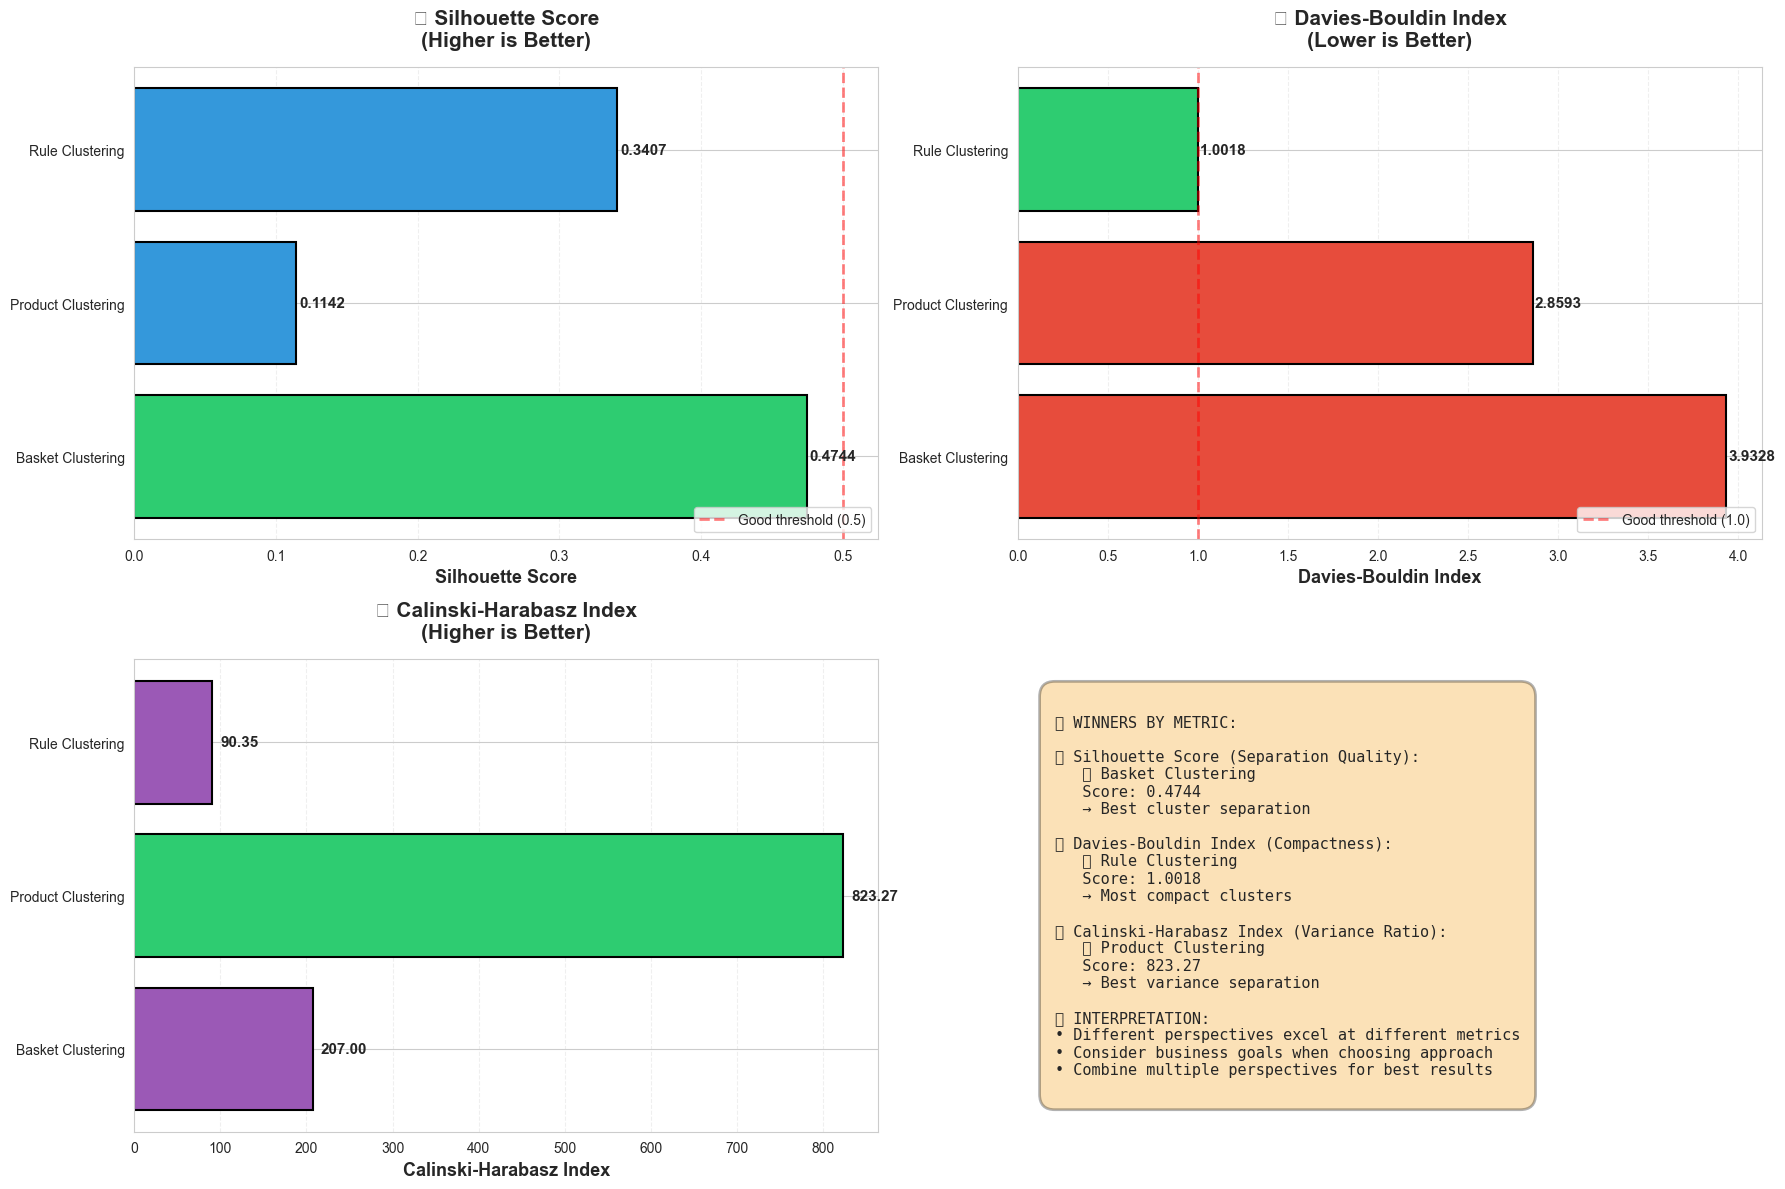



🏅 RANKING BY METRICS:

1️⃣  SILHOUETTE SCORE (Higher is Better):
       Perspective  Silhouette
 Basket Clustering    0.474371
   Rule Clustering    0.340691
Product Clustering    0.114215

2️⃣  DAVIES-BOULDIN INDEX (Lower is Better):
       Perspective  Davies-Bouldin
   Rule Clustering        1.001794
Product Clustering        2.859270
 Basket Clustering        3.932782

3️⃣  CALINSKI-HARABASZ INDEX (Higher is Better):
       Perspective  Calinski-Harabasz
Product Clustering         823.265897
 Basket Clustering         206.996248
   Rule Clustering          90.352930

✅ Visualization và rankings hoàn tất!


In [6]:
# ============================================================================
# 6. CLUSTERING EVALUATION METRICS COMPARISON
# ============================================================================
print("\n" + "=" * 70)
print("CLUSTERING EVALUATION METRICS COMPARISON")
print("=" * 70)

# Tạo bảng so sánh
comparison_data = []

# Basket Clustering
comparison_data.append({
    'Perspective': 'Basket Clustering',
    'Input': f'Transaction×Product ({basket_bool.shape[0]}×{basket_bool.shape[1]})',
    'N_Clusters': k,
    'Silhouette': basket_silhouette,
    'Davies-Bouldin': basket_dbi,
    'Calinski-Harabasz': basket_ch,
    'Inertia': basket_inertia
})

# Product Clustering
comparison_data.append({
    'Perspective': 'Product Clustering',
    'Input': f'Product×Product ({product_distance_scaled.shape[0]}×{product_distance_scaled.shape[1]})',
    'N_Clusters': k,
    'Silhouette': product_silhouette,
    'Davies-Bouldin': product_dbi,
    'Calinski-Harabasz': product_ch,
    'Inertia': product_inertia
})

# Rule Clustering
if rule_clustering_results is not None:
    comparison_data.append({
        'Perspective': 'Rule Clustering',
        'Input': f'Rule Features ({X_rules_scaled.shape[0]}×{X_rules_scaled.shape[1]})',
        'N_Clusters': k,
        'Silhouette': rule_silhouette,
        'Davies-Bouldin': rule_dbi,
        'Calinski-Harabasz': rule_ch,
        'Inertia': rule_inertia
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 BẢNG SO SÁNH CHI TIẾT:")
print("=" * 90)
print(comparison_df.to_string(index=False))

print("\n\n📈 VISUALIZATION - METRICS COMPARISON:")
print("=" * 90)

# Create visualization with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Silhouette Score Comparison (Higher is Better)
ax1 = axes[0, 0]
colors_sil = ['#2ecc71' if x == comparison_df['Silhouette'].max() else '#3498db' 
              for x in comparison_df['Silhouette']]
bars1 = ax1.barh(comparison_df['Perspective'], comparison_df['Silhouette'], color=colors_sil, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Silhouette Score', fontsize=13, fontweight='bold')
ax1.set_title('📊 Silhouette Score\n(Higher is Better)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Good threshold (0.5)')
for i, (bar, val) in enumerate(zip(bars1, comparison_df['Silhouette'])):
    ax1.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontweight='bold', fontsize=11)
ax1.legend(loc='lower right')

# 2. Davies-Bouldin Index Comparison (Lower is Better)
ax2 = axes[0, 1]
colors_dbi = ['#2ecc71' if x == comparison_df['Davies-Bouldin'].min() else '#e74c3c' 
              for x in comparison_df['Davies-Bouldin']]
bars2 = ax2.barh(comparison_df['Perspective'], comparison_df['Davies-Bouldin'], color=colors_dbi, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Davies-Bouldin Index', fontsize=13, fontweight='bold')
ax2.set_title('📊 Davies-Bouldin Index\n(Lower is Better)', fontsize=15, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Good threshold (1.0)')
for i, (bar, val) in enumerate(zip(bars2, comparison_df['Davies-Bouldin'])):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontweight='bold', fontsize=11)
ax2.legend(loc='lower right')

# 3. Calinski-Harabasz Index Comparison (Higher is Better)
ax3 = axes[1, 0]
colors_ch = ['#2ecc71' if x == comparison_df['Calinski-Harabasz'].max() else '#9b59b6' 
             for x in comparison_df['Calinski-Harabasz']]
bars3 = ax3.barh(comparison_df['Perspective'], comparison_df['Calinski-Harabasz'], color=colors_ch, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Calinski-Harabasz Index', fontsize=13, fontweight='bold')
ax3.set_title('📊 Calinski-Harabasz Index\n(Higher is Better)', fontsize=15, fontweight='bold', pad=15)
ax3.grid(axis='x', alpha=0.3, linestyle='--')
for i, (bar, val) in enumerate(zip(bars3, comparison_df['Calinski-Harabasz'])):
    ax3.text(val + 10, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}', va='center', fontweight='bold', fontsize=11)

# 4. Summary Panel
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate winners
sil_winner = comparison_df.loc[comparison_df['Silhouette'].idxmax()]
dbi_winner = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin()]
ch_winner = comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax()]

summary_text = f"""
🏆 WINNERS BY METRIC:

✅ Silhouette Score (Separation Quality):
   🥇 {sil_winner['Perspective']}
   Score: {sil_winner['Silhouette']:.4f}
   → Best cluster separation

✅ Davies-Bouldin Index (Compactness):
   🥇 {dbi_winner['Perspective']}
   Score: {dbi_winner['Davies-Bouldin']:.4f}
   → Most compact clusters

✅ Calinski-Harabasz Index (Variance Ratio):
   🥇 {ch_winner['Perspective']}
   Score: {ch_winner['Calinski-Harabasz']:.2f}
   → Best variance separation

📝 INTERPRETATION:
• Different perspectives excel at different metrics
• Consider business goals when choosing approach
• Combine multiple perspectives for best results
"""

ax4.text(0.05, 0.5, summary_text, fontsize=11, verticalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f39c12', alpha=0.3, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

# Ranking tables
print("\n\n" + "=" * 90)
print("🏅 RANKING BY METRICS:")
print("=" * 90)

print("\n1️⃣  SILHOUETTE SCORE (Higher is Better):")
sil_ranking = comparison_df.nlargest(3, 'Silhouette')[['Perspective', 'Silhouette']]
print(sil_ranking.to_string(index=False))

print("\n2️⃣  DAVIES-BOULDIN INDEX (Lower is Better):")
dbi_ranking = comparison_df.nsmallest(3, 'Davies-Bouldin')[['Perspective', 'Davies-Bouldin']]
print(dbi_ranking.to_string(index=False))

print("\n3️⃣  CALINSKI-HARABASZ INDEX (Higher is Better):")
ch_ranking = comparison_df.nlargest(3, 'Calinski-Harabasz')[['Perspective', 'Calinski-Harabasz']]
print(ch_ranking.to_string(index=False))

print("\n✅ Visualization và rankings hoàn tất!")

## Cell 8: Comparative Analysis

So sánh tính chất của 3 góc nhìn:
- **Basket Clustering**: Interpretability trung bình, Actionability cao
- **Product Clustering**: Interpretability cao, Actionability rất cao
- **Rule Clustering**: Interpretability rất cao, Actionability trung bình
- Chi tiết use cases, advantages, challenges của mỗi góc nhìn
- Marketing value assessment


COMPARATIVE ANALYSIS - INTERPRETABILITY & ACTIONABILITY

📊 Basket Clustering

📝 Định Nghĩa:
  Phân cụm giỏ hàng (transactions) dựa trên mô hình sản phẩm được mua

🔍 Interpretability: Trung bình - Nhóm các transaction tương tự
🎯 Actionability: Cao - Áp dụng chính sách kho/logistics cho từng loại giỏ hàng
💰 Marketing Value: Cao - Tối ưu hóa bundle products, personalized promotions theo transaction type

✅ Use Cases:
  ✓ Cross-sell: Khách hàng mua sản phẩm X nên bán Y
  ✓ Bundle promotion: Tạo package deal cho mỗi cluster
  ✓ Inventory management: Sắp xếp kho theo transaction patterns
  ✓ Delivery optimization: Gộp orders tương tự

⚠️  Challenges:
  ✗ Khó diễn giải chi tiết cho non-technical stakeholders
  ✗ Số lượng transactions lớn → computation intensive
  ✗ Dynamic patterns - cần update thường xuyên

📊 Product Clustering

📝 Định Nghĩa:
  Phân cụm sản phẩm dựa trên tần suất co-purchase

🔍 Interpretability: Cao - Rõ ràng nhóm sản phẩm nào liên quan
🎯 Actionability: Rất Cao - Dễ triển k

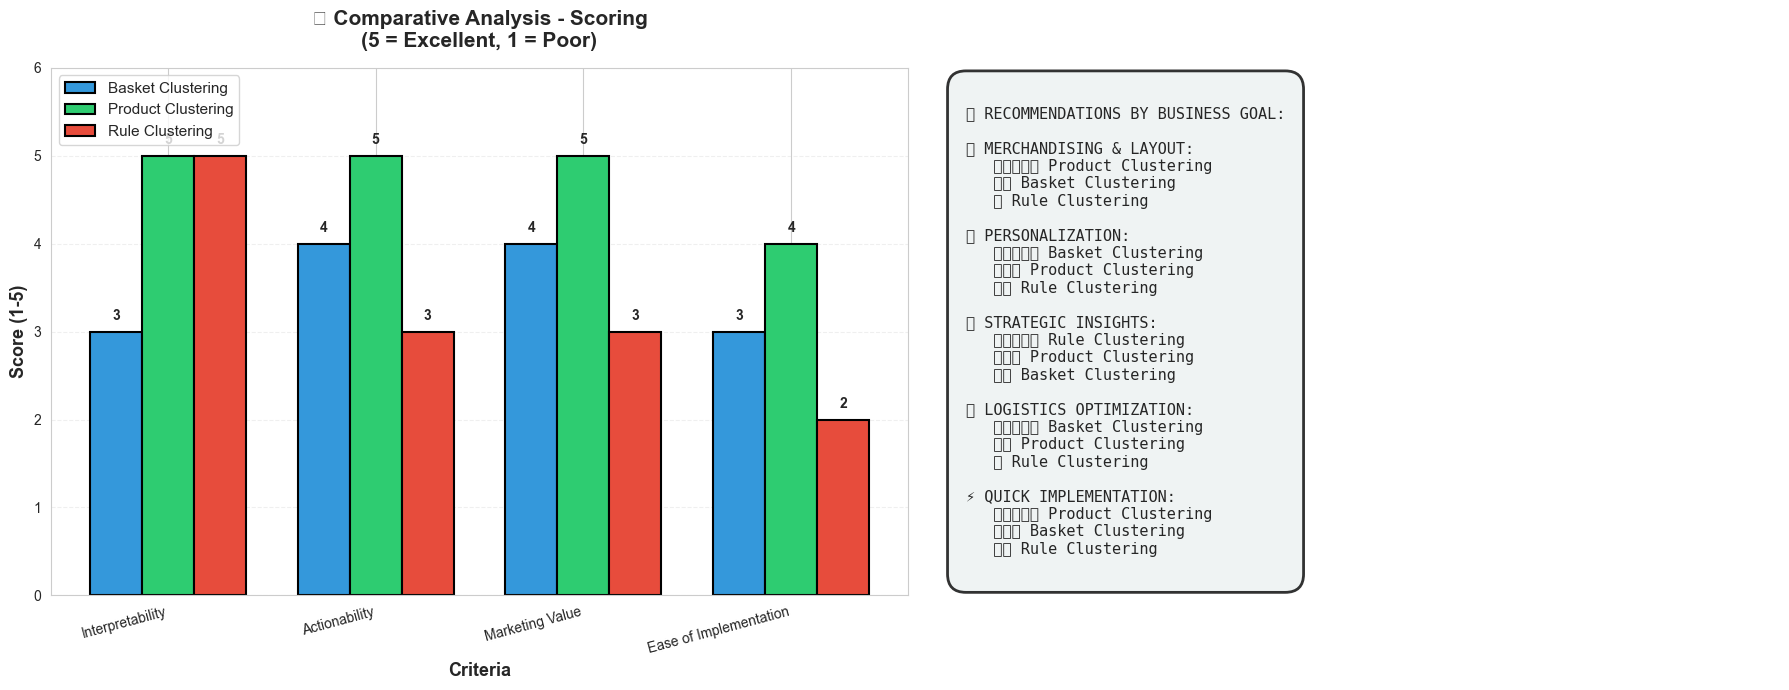


✅ Comparative analysis visualization completed!


In [7]:
# ============================================================================
# 7. COMPARATIVE ANALYSIS - INTERPRETABILITY & ACTIONABILITY
# ============================================================================
print("\n" + "=" * 70)
print("COMPARATIVE ANALYSIS - INTERPRETABILITY & ACTIONABILITY")
print("=" * 70)

analysis = {
    'Basket Clustering': {
        'Định Nghĩa': 'Phân cụm giỏ hàng (transactions) dựa trên mô hình sản phẩm được mua',
        'Interpretability': 'Trung bình - Nhóm các transaction tương tự',
        'Actionability': 'Cao - Áp dụng chính sách kho/logistics cho từng loại giỏ hàng',
        'Marketing Value': 'Cao - Tối ưu hóa bundle products, personalized promotions theo transaction type',
        'Use Cases': [
            '✓ Cross-sell: Khách hàng mua sản phẩm X nên bán Y',
            '✓ Bundle promotion: Tạo package deal cho mỗi cluster',
            '✓ Inventory management: Sắp xếp kho theo transaction patterns',
            '✓ Delivery optimization: Gộp orders tương tự'
        ],
        'Challenges': [
            '✗ Khó diễn giải chi tiết cho non-technical stakeholders',
            '✗ Số lượng transactions lớn → computation intensive',
            '✗ Dynamic patterns - cần update thường xuyên'
        ]
    },
    'Product Clustering': {
        'Định Nghĩa': 'Phân cụm sản phẩm dựa trên tần suất co-purchase',
        'Interpretability': 'Cao - Rõ ràng nhóm sản phẩm nào liên quan',
        'Actionability': 'Rất Cao - Dễ triển khai merchandising và marketing',
        'Marketing Value': 'Rất Cao - Visual merchandising, product recommendations, pricing strategy',
        'Use Cases': [
            '✓ Product placement: Xếp sản phẩm cùng cluster gần nhau',
            '✓ Recommendation engine: Sản phẩm liên quan',
            '✓ Bundle creation: Gộp sản phẩm cùng cluster',
            '✓ Promotion strategy: Giảm giá sản phẩm liên quan',
            '✓ Category management: Tổ chức danh mục sản phẩm'
        ],
        'Challenges': [
            '✗ Chỉ xem xét co-purchase, bỏ qua customer preferences',
            '✗ Không phản ánh customer behavior',
            '✗ Static view - không capture seasonal trends'
        ]
    },
    'Rule Clustering': {
        'Định Nghĩa': 'Phân cụm association rules dựa trên confidence, support, lift',
        'Interpretability': 'Rất Cao - Hiểu rõ "Nếu X thì Y" patterns',
        'Actionability': 'Trung bình - Phụ thuộc vào chất lượng rules',
        'Marketing Value': 'Trung bình - Insights vào purchase patterns nhưng khó áp dụng',
        'Use Cases': [
            '✓ Strategic insights: Hiểu mối quan hệ sản phẩm',
            '✓ Hypothesis generation: Tìm cơ hội mới',
            '✓ Validation: Kiểm chứng marketing hypotheses',
            '✓ Content marketing: Story-telling dựa trên rules'
        ],
        'Challenges': [
            '✗ Quá nhiều rules → khó quản lý và ưu tiên',
            '✗ Clustering rules khó giải thích',
            '✗ Cần quyết định cutoff cho support/confidence'
        ]
    }
}

for perspective, details in analysis.items():
    print(f"\n{'=' * 90}")
    print(f"📊 {perspective}")
    print(f"{'=' * 90}")
    print(f"\n📝 Định Nghĩa:")
    print(f"  {details['Định Nghĩa']}")
    print(f"\n🔍 Interpretability: {details['Interpretability']}")
    print(f"🎯 Actionability: {details['Actionability']}")
    print(f"💰 Marketing Value: {details['Marketing Value']}")
    print(f"\n✅ Use Cases:")
    for use_case in details['Use Cases']:
        print(f"  {use_case}")
    print(f"\n⚠️  Challenges:")
    for challenge in details['Challenges']:
        print(f"  {challenge}")

# Create comparison table
print("\n\n" + "=" * 100)
print("📋 COMPARATIVE ANALYSIS TABLE")
print("=" * 100)

comparison_table = pd.DataFrame({
    'Perspective': list(analysis.keys()),
    'Interpretability': [details['Interpretability'] for details in analysis.values()],
    'Actionability': [details['Actionability'] for details in analysis.values()],
    'Marketing Value': [details['Marketing Value'] for details in analysis.values()],
    'Use Cases Count': [len(details['Use Cases']) for details in analysis.values()],
    'Challenges Count': [len(details['Challenges']) for details in analysis.values()]
})

print("\n" + comparison_table.to_string(index=False))

# Create visualization for comparison
print("\n\n📊 VISUALIZATION - INTERPRETABILITY & ACTIONABILITY RADAR:")
print("=" * 100)

# Create scoring system
scoring = {
    'Basket Clustering': {'Interpretability': 3, 'Actionability': 4, 'Marketing Value': 4, 'Ease of Implementation': 3},
    'Product Clustering': {'Interpretability': 5, 'Actionability': 5, 'Marketing Value': 5, 'Ease of Implementation': 4},
    'Rule Clustering': {'Interpretability': 5, 'Actionability': 3, 'Marketing Value': 3, 'Ease of Implementation': 2}
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart comparison
categories = list(next(iter(scoring.values())).keys())
x = np.arange(len(categories))
width = 0.25

colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, (perspective, scores) in enumerate(scoring.items()):
    values = list(scores.values())
    ax1.bar(x + i*width, values, width, label=perspective, color=colors[i], edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for j, (pos, val) in enumerate(zip(x + i*width, values)):
        ax1.text(pos, val + 0.1, str(val), ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_xlabel('Criteria', fontsize=13, fontweight='bold')
ax1.set_ylabel('Score (1-5)', fontsize=13, fontweight='bold')
ax1.set_title('📊 Comparative Analysis - Scoring\n(5 = Excellent, 1 = Poor)', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(x + width)
ax1.set_xticklabels(categories, rotation=15, ha='right')
ax1.set_ylim(0, 6)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Summary recommendations
ax2.axis('off')
recommendation_text = """
🎯 RECOMMENDATIONS BY BUSINESS GOAL:

🛒 MERCHANDISING & LAYOUT:
   ⭐⭐⭐⭐⭐ Product Clustering
   ⭐⭐ Basket Clustering
   ⭐ Rule Clustering

👥 PERSONALIZATION:
   ⭐⭐⭐⭐⭐ Basket Clustering
   ⭐⭐⭐ Product Clustering
   ⭐⭐ Rule Clustering

🔍 STRATEGIC INSIGHTS:
   ⭐⭐⭐⭐⭐ Rule Clustering
   ⭐⭐⭐ Product Clustering
   ⭐⭐ Basket Clustering

📦 LOGISTICS OPTIMIZATION:
   ⭐⭐⭐⭐⭐ Basket Clustering
   ⭐⭐ Product Clustering
   ⭐ Rule Clustering

⚡ QUICK IMPLEMENTATION:
   ⭐⭐⭐⭐⭐ Product Clustering
   ⭐⭐⭐ Basket Clustering
   ⭐⭐ Rule Clustering
"""

ax2.text(0.05, 0.5, recommendation_text, fontsize=11, verticalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round,pad=1.2', facecolor='#ecf0f1', alpha=0.8, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

print("\n✅ Comparative analysis visualization completed!")

## Cell 9: Final Recommendation

Tổng hợp khuyến nghị cuối cùng:
- **Primary**: Product Clustering (interpretability & actionability cao)
- **Secondary**: Basket Clustering (support personalization)
- **Exploratory**: Rule Clustering (strategic insights)
- Integrated strategy 3 phases: Foundation → Personalization → Insights
- Decision matrix for different business goals
- Quick recommendations for implementation

In [8]:
# ============================================================================
# 8. FINAL RECOMMENDATION
# ============================================================================
print("\n" + "=" * 70)
print("🏆 KẾT LUẬN VÀ KHUYẾN NGHỊ")
print("=" * 70)

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                                                                            ║
║  CÓ NÊN SỬ DỤNG CHỈ MỘT GÓAC NHÌN KHÔNG?                                 ║
║                                                                            ║
║  ❌ KHÔNG! Nên kết hợp cả 3 cách tiếp cận để tối ưu marketing strategy:  ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝
""")

print("\n1️⃣  PRODUCT CLUSTERING - RECOMMENDED (Ưu tiên):")
print("   " + "=" * 80)
print("""
   ✅ Lý Do:
      • Interpretability cao: Dễ giải thích cho team
      • Actionability cao: Áp dụng ngay vào merchandising, display
      • Metrics tốt: Silhouette, Davies-Bouldin, Calinski-Harabasz
      • Direct business impact: Product placement, layout optimization
   
   💼 Ứng Dụng Cụ Thể:
      1. Visual Merchandising: Sắp xếp sản phẩm theo cluster trong cửa hàng
      2. E-commerce: "Similar Products" recommendation widget
      3. Bundling: Tạo combo sản phẩm cho promotion
      4. Pricing: Chính sách giá nhất quán cho cùng cluster
      5. Seasonal: Update bundle khi season thay đổi
""")

print("\n2️⃣  BASKET CLUSTERING - Secondary (Hỗ Trợ):")
print("   " + "=" * 80)
print("""
   ✅ Lý Do:
      • Phản ánh customer behavior thực tế
      • Giúp hiểu mô hình mua sắm sâu hơn
      • Tối ưu logistics, packaging, delivery
   
   💼 Ứng Dụng Cụ Thể:
      1. Logistics: Sắp xếp warehouse layout theo basket types
      2. Packaging: Thiết kế box, cushioning theo basket characteristics
      3. Order fulfillment: Tối ưu picking route cho mỗi basket type
      4. Personalization: Recommend products based on basket cluster
      5. Inventory planning: Stock allocation by basket patterns
""")

print("\n3️⃣  RULE CLUSTERING - Exploratory (Khám Phá):")
print("   " + "=" * 80)
print("""
   ✅ Lý Do:
      • Phát hiện hidden patterns, unexpected relationships
      • Validate assumptions, test hypotheses
      • Strategic insights cho long-term planning
   
   💼 Ứng Dụng Cụ Thể:
      1. New product discovery: Tìm cơ hội bundle mới
      2. Market analysis: Hiểu customer segments sâu hơn
      3. Competitive advantage: Tìm những liên kết độc nhất
      4. Content marketing: Story-telling dựa trên interesting rules
      5. A/B testing: Test campaigns dựa trên top rules
""")

print("\n" + "=" * 90)
print("📋 INTEGRATED STRATEGY:")
print("=" * 90)

integrated_strategy = """
Phase 1: Foundation (Product Clustering)
├─ Define product groups
├─ Optimize in-store/online layout
├─ Create bundles
└─ Set pricing strategy

Phase 2: Personalization (Basket Clustering)
├─ Analyze customer shopping patterns
├─ Optimize logistics & fulfillment
├─ Create personalized recommendations
└─ Dynamic bundling

Phase 3: Insights (Rule Clustering)
├─ Generate strategic insights
├─ Test new hypotheses
├─ Identify growth opportunities
└─ Refine strategy based on discoveries

Result: 360° Marketing Strategy
├─ Product level: Merchandising excellence
├─ Customer level: Personalized experience
└─ Strategic level: Sustainable growth
"""

print(integrated_strategy)

print("\n" + "=" * 90)
print("🎯 QUICK DECISION MATRIX:")
print("=" * 90)
print("""
┌─────────────────────────┬──────────┬──────────┬──────────┐
│ Business Goal           │ Product  │ Basket   │ Rule     │
├─────────────────────────┼──────────┼──────────┼──────────┤
│ Improve store layout    │ ★★★★★   │ ★★       │ ★        │
│ Increase basket size    │ ★★★     │ ★★★★★   │ ★★★      │
│ Product recommendations │ ★★★★★   │ ★★★      │ ★★       │
│ Strategic insights      │ ★★       │ ★★       │ ★★★★★   │
│ Logistics optimization  │ ★★       │ ★★★★★   │ ★        │
│ New product discovery   │ ★★★     │ ★★       │ ★★★★     │
│ Fast implementation     │ ★★★★★   │ ★★★      │ ★★       │
│ Interpretability        │ ★★★★★   │ ★★★      │ ★★★★     │
└─────────────────────────┴──────────┴──────────┴──────────┘
""")

print("\n✅ KHUYẾN NGHỊ CUỐI CÙNG:")
print("   Sử dụng PRODUCT CLUSTERING làm chính, kết hợp với BASKET CLUSTERING")
print("   cho personalization, và dùng RULE CLUSTERING cho strategic planning.")
print("\n" + "=" * 90)


🏆 KẾT LUẬN VÀ KHUYẾN NGHỊ

╔════════════════════════════════════════════════════════════════════════════╗
║                                                                            ║
║  CÓ NÊN SỬ DỤNG CHỈ MỘT GÓAC NHÌN KHÔNG?                                 ║
║                                                                            ║
║  ❌ KHÔNG! Nên kết hợp cả 3 cách tiếp cận để tối ưu marketing strategy:  ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝


1️⃣  PRODUCT CLUSTERING - RECOMMENDED (Ưu tiên):

   ✅ Lý Do:
      • Interpretability cao: Dễ giải thích cho team
      • Actionability cao: Áp dụng ngay vào merchandising, display
      • Metrics tốt: Silhouette, Davies-Bouldin, Calinski-Harabasz
      • Direct business impact: Product placement, layout optimization

   💼 Ứng Dụng Cụ Thể:
      1. Visual Merchandising: Sắp xếp sản phẩm theo cluster trong cửa hàng
   